In [1]:
import fastf1
from fastf1 import plotting
from fastf1.core import Laps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
years = [2021, 2022, 2023, 2024, 2025]
event_name = "British Grand Prix"
driver_abbr = "VER"

## Step 1: Load Sessions and Filter Driver Laps

We collect lap data from `FP1`, `FP2`, `FP3`, `Q`, and `R` sessions between 2021–2025 using FastF1.
Only quick laps by the selected driver are retained. Each lap is tagged with year and session type.

In [3]:
all_laps = []
session_types = ['FP1', 'FP2', 'FP3', 'Q', 'R']  # Practice, Qualifying, Race

for year in years:
    for session_type in session_types:
        try:
            session = fastf1.get_session(year, event_name, session_type)
            session.load()

            driver_laps = session.laps.pick_driver(driver_abbr).pick_quicklaps().copy()
            driver_laps['Year'] = year
            driver_laps['SessionType'] = session_type
            driver_laps['Session'] = session

            all_laps.append(driver_laps)

        except Exception as e:
            print(f"Skipping {year} {session_type}: {e}")

req         WARNING 	DEFAULT CACHE ENABLED! (1.58 GB) C:\Users\aayus\AppData\Local\Temp\fastf1
core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
C:\Users\aayus\O

Skipping 2021 FP3: Session type 'FP3' does not exist for this event


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '4', '3', '63', '55', '5', '14', '10', '31', '99', '18', '22', '7', '6', '47', '9']
C:\Users\aayus\OneDrive\Desktop\DESKTOP\Project\Personal\ML Projects\f1\venv\Lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core        

In [4]:
print(session.laps.columns)

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')


## Step 2: Merge Weather Data

For each lap, we find the closest weather snapshot (AirTemp, TrackTemp) using session time alignment.
This gives us temperature conditions at the moment the lap started.

In [5]:
weather = session.weather_data

In [6]:
final_laps = []

for df in all_laps:
    if df.empty:
        continue

    year = df['Year'].iloc[0]
    session_type = df['SessionType'].iloc[0]
    
    try:
        session = fastf1.get_session(year, event_name, session_type)
        session.load()

        weather = session.weather_data.copy()
        weather['Time'] = pd.to_timedelta(weather['Time'])

        def get_closest_weather(lap_time):
            delta = (weather['Time'] - pd.to_timedelta(lap_time)).abs()
            return weather.loc[delta.idxmin()]

        weather_features = []
        for lap_start_time in df['LapStartTime']:
            w = get_closest_weather(lap_start_time)
            weather_features.append(w)

        weather_df = pd.DataFrame(weather_features).reset_index(drop=True)
        df = pd.concat([df.reset_index(drop=True), weather_df[['AirTemp', 'TrackTemp']]], axis=1)

        final_laps.append(df)

    except Exception as e:
        print(f"Weather join failed for {year} {session_type}: {e}")


core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.5.3]
req            INFO 	Using cache

In [7]:
laps_df = pd.concat(final_laps).reset_index(drop=True)

In [8]:
laps_df.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year', 'SessionType', 'Session',
       'AirTemp', 'TrackTemp'],
      dtype='object')

## Step 3: Keep Necessary Cols

For each data we keep only the necessary features('LapTime', 'LapNumber', 'Compound', 'TyreLife','TrackStatus', 'AirTemp', 'TrackTemp', 'IsAccurate', 'Time', 'LapStartTime',) 

In [9]:
selected_cols = [
    'LapTime', 'LapNumber', 'Compound', 'TyreLife',
    'TrackStatus', 'AirTemp', 'TrackTemp',
    'IsAccurate', 'Time', 'LapStartTime', 'Session', 'Year'
]
laps_df = laps_df[selected_cols]

In [10]:
laps_df.head()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,IsAccurate,Time,LapStartTime,Session,Year
0,0 days 00:01:30.274000,2.0,HARD,2.0,1,24.6,43.2,True,0 days 00:18:45.543000,0 days 00:17:15.269000,2021 Season Round 10: British Grand Prix - Pra...,2021
1,0 days 00:01:30.459000,4.0,HARD,4.0,1,24.6,46.1,True,0 days 00:22:22.936000,0 days 00:20:52.477000,2021 Season Round 10: British Grand Prix - Pra...,2021
2,0 days 00:01:28.179000,7.0,MEDIUM,2.0,1,25.1,43.7,True,0 days 00:34:26.109000,0 days 00:32:57.930000,2021 Season Round 10: British Grand Prix - Pra...,2021
3,0 days 00:01:27.745000,9.0,MEDIUM,4.0,1,25.3,45.5,True,0 days 00:38:07.765000,0 days 00:36:40.020000,2021 Season Round 10: British Grand Prix - Pra...,2021
4,0 days 00:01:27.035000,12.0,SOFT,2.0,1,25.5,47.2,True,0 days 00:53:11.343000,0 days 00:51:44.308000,2021 Season Round 10: British Grand Prix - Pra...,2021


In [11]:
laps_df.tail()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,IsAccurate,Time,LapStartTime,Session,Year
290,0 days 00:01:30.776000,48.0,MEDIUM,7.0,1,19.2,23.6,True,0 days 02:28:18.895000,0 days 02:26:48.119000,2025 Season Round 12: British Grand Prix - Race,2025
291,0 days 00:01:30.179000,49.0,MEDIUM,8.0,1,19.1,23.7,True,0 days 02:29:49.074000,0 days 02:28:18.895000,2025 Season Round 12: British Grand Prix - Race,2025
292,0 days 00:01:30.290000,50.0,MEDIUM,9.0,1,19.2,24.4,True,0 days 02:31:19.364000,0 days 02:29:49.074000,2025 Season Round 12: British Grand Prix - Race,2025
293,0 days 00:01:30.973000,51.0,MEDIUM,10.0,1,19.4,24.4,True,0 days 02:32:50.337000,0 days 02:31:19.364000,2025 Season Round 12: British Grand Prix - Race,2025
294,0 days 00:01:31.389000,52.0,MEDIUM,11.0,1,19.5,24.6,True,0 days 02:34:21.726000,0 days 02:32:50.337000,2025 Season Round 12: British Grand Prix - Race,2025


In [12]:
laps_df = laps_df[laps_df['IsAccurate'] == True].reset_index(drop=True)
laps_df.head()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,IsAccurate,Time,LapStartTime,Session,Year
0,0 days 00:01:30.274000,2.0,HARD,2.0,1,24.6,43.2,True,0 days 00:18:45.543000,0 days 00:17:15.269000,2021 Season Round 10: British Grand Prix - Pra...,2021
1,0 days 00:01:30.459000,4.0,HARD,4.0,1,24.6,46.1,True,0 days 00:22:22.936000,0 days 00:20:52.477000,2021 Season Round 10: British Grand Prix - Pra...,2021
2,0 days 00:01:28.179000,7.0,MEDIUM,2.0,1,25.1,43.7,True,0 days 00:34:26.109000,0 days 00:32:57.930000,2021 Season Round 10: British Grand Prix - Pra...,2021
3,0 days 00:01:27.745000,9.0,MEDIUM,4.0,1,25.3,45.5,True,0 days 00:38:07.765000,0 days 00:36:40.020000,2021 Season Round 10: British Grand Prix - Pra...,2021
4,0 days 00:01:27.035000,12.0,SOFT,2.0,1,25.5,47.2,True,0 days 00:53:11.343000,0 days 00:51:44.308000,2021 Season Round 10: British Grand Prix - Pra...,2021


In [13]:
inaccurate_laps = laps_df[laps_df['IsAccurate'] == False]

inaccurate_laps.head()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,IsAccurate,Time,LapStartTime,Session,Year


In [14]:
compound_map = {
    'SOFT': 0,
    'MEDIUM': 1,
    'HARD': 2,
    'INTERMEDIATE': 3,
    'WET': 4
}
laps_df['Compound'] = laps_df['Compound'].map(compound_map)

In [15]:
laps_df.tail()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,IsAccurate,Time,LapStartTime,Session,Year
284,0 days 00:01:30.776000,48.0,1,7.0,1,19.2,23.6,True,0 days 02:28:18.895000,0 days 02:26:48.119000,2025 Season Round 12: British Grand Prix - Race,2025
285,0 days 00:01:30.179000,49.0,1,8.0,1,19.1,23.7,True,0 days 02:29:49.074000,0 days 02:28:18.895000,2025 Season Round 12: British Grand Prix - Race,2025
286,0 days 00:01:30.290000,50.0,1,9.0,1,19.2,24.4,True,0 days 02:31:19.364000,0 days 02:29:49.074000,2025 Season Round 12: British Grand Prix - Race,2025
287,0 days 00:01:30.973000,51.0,1,10.0,1,19.4,24.4,True,0 days 02:32:50.337000,0 days 02:31:19.364000,2025 Season Round 12: British Grand Prix - Race,2025
288,0 days 00:01:31.389000,52.0,1,11.0,1,19.5,24.6,True,0 days 02:34:21.726000,0 days 02:32:50.337000,2025 Season Round 12: British Grand Prix - Race,2025


In [16]:
laps_df = laps_df.drop(columns=['IsAccurate'])

In [17]:
laps_df.head()

,LapTime,LapNumber,Compound,TyreLife,TrackStatus,AirTemp,TrackTemp,Time,LapStartTime,Session,Year
0,0 days 00:01:30.274000,2.0,2,2.0,1,24.6,43.2,0 days 00:18:45.543000,0 days 00:17:15.269000,2021 Season Round 10: British Grand Prix - Pra...,2021
1,0 days 00:01:30.459000,4.0,2,4.0,1,24.6,46.1,0 days 00:22:22.936000,0 days 00:20:52.477000,2021 Season Round 10: British Grand Prix - Pra...,2021
2,0 days 00:01:28.179000,7.0,1,2.0,1,25.1,43.7,0 days 00:34:26.109000,0 days 00:32:57.930000,2021 Season Round 10: British Grand Prix - Pra...,2021
3,0 days 00:01:27.745000,9.0,1,4.0,1,25.3,45.5,0 days 00:38:07.765000,0 days 00:36:40.020000,2021 Season Round 10: British Grand Prix - Pra...,2021
4,0 days 00:01:27.035000,12.0,0,2.0,1,25.5,47.2,0 days 00:53:11.343000,0 days 00:51:44.308000,2021 Season Round 10: British Grand Prix - Pra...,2021


In [18]:
laps_df.to_csv('ver_laps_silverstone.csv', index=False)

In [19]:
from tqdm import tqdm

In [20]:
telemetry_sequences = []
invalid_laps = []

time_window = 15.0 #seconds
time_resolution = 0.1 #seconds
target_length = int(time_window/time_resolution) #150 steps

In [21]:
for lap in tqdm(laps_df.itertuples(), total=len(laps_df)):
    try:
        session = lap.Session
        lap_number = lap.LapNumber

        lap_obj = session.laps[session.laps['LapNumber'] == lap_number].iloc[0]
        tel = lap_obj.get_car_data().add_distance()

        # Use relative time (much cleaner)
        tel['RelTime'] = (tel['Time'] - tel['Time'].iloc[0]).dt.total_seconds()
        tel = tel[tel['RelTime'] <= time_window]

        # Reindex to uniform time steps
        tel = tel.set_index('RelTime')[['Speed', 'Throttle', 'Brake']]
        tel = tel.reindex(np.arange(0, time_window, time_resolution), method='nearest', fill_value=0)

        if tel.shape[0] == target_length:
            telemetry_sequences.append(tel.values)
        else:
            invalid_laps.append(lap_number)

    except Exception as e:
        print(f"Skipping lap {lap.LapNumber} due to error: {e}")
        invalid_laps.append(lap.LapNumber)

telemetry_data = np.array(telemetry_sequences)
print("Final shape:", telemetry_data.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:08<00:00, 34.73it/s]

Final shape: (289, 150, 3)


In [22]:
telemetry_data = np.array(telemetry_sequences)

In [23]:
print(telemetry_data.shape)

(289, 150, 3)


In [24]:
np.save("ver_silverstone_telemetry_data.npy", telemetry_data)

[[80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 36.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 False]
 [80.0 37.0 

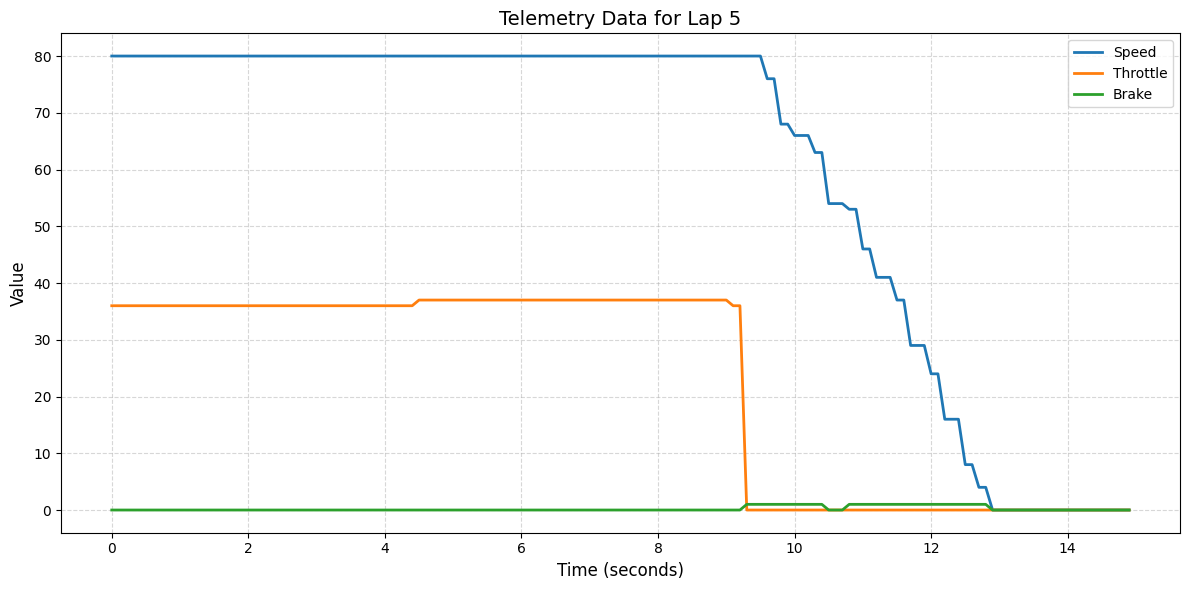

In [25]:
time_axis = np.arange(telemetry_data.shape[1]) * 0.1  
features = ['Speed', 'Throttle', 'Brake']
lap_index = 5


print(telemetry_data[lap_index])
# Extract data for the selected lap
lap_data = telemetry_data[lap_index]

# Create the plot
plt.figure(figsize=(12, 6))
for i in range(lap_data.shape[1]):
    plt.plot(time_axis, lap_data[:, i], label=features[i], linewidth=2)

plt.title(f"Telemetry Data for Lap {lap_index}", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
